In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

### まず実験結果の読み込み

In [4]:
targetDir = "../data/output/Result1/Result/"
speedDir = "../data/output/Result1/Speed/"
brakeDir = "../data/output/Result1/Brake/"
accelDIr = "../data/output/Result1/Accel/"
steeringPositiveDir = "../data/output/Result1/SteeringPositive/"
steeringNegativeDir = "../data/output/Result1/SteeringNegative/"
manyCarDir = "../data/output/Result1/ManyCars/"
middleCarDir = "../data/output/Result1/MiddleCars/"
lessCarDir = "../data/output/Result1/LessCars/"
afternoonSunMax = "../data/output/Result1/AfternoonSunMax/"
afternoonSunMiddle = "../data/output/Result1/AfternoonSunMiddle/"
afternoonSunMin = "../data/output/Result1/AfternoonSunMin/"
cloudMax = "../data/output/Result1/CloudMax/"
cloudMiddle = "../data/output/Result1/CloudMiddle/"
cloudMin = "../data/output/Result1/CloudMin/"
sunshineMax = "../data/output/Result1/SunshineMax/"
sunshineMiddle = "../data/output/Result1/SunshineMiddle/"
sunshineMin = "../data/output/Result1/SunshineMin/"

### 読み込んだデータを元に data-frame を作成

In [5]:
df1 = pd.read_csv(speedDir + "result.csv")
df1.columns = [["id", "red", "yellow", "green", "slow"]]
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(afternoonSunMax + "result.csv")
df6.columns = [["id", "sunMax"]]
df7 = pd.read_csv(afternoonSunMiddle + "result.csv")
df7.columns = [["id", "sunMiddle"]]
df8 = pd.read_csv(afternoonSunMin + "result.csv")
df8.columns = [["id", "sunMin"]]
df9 = pd.read_csv(cloudMax + "result.csv")
df9.columns = [["id", "cloudMax"]]
df10 = pd.read_csv(cloudMiddle + "result.csv")
df10.columns = [["id", "cloudMiddle"]]
df11 = pd.read_csv(cloudMin + "result.csv")
df11.columns = [["id", "cloudMin"]]
df12 = pd.read_csv(sunshineMax + "result.csv")
df12.columns = [["id", "shineMax"]]
df13 = pd.read_csv(sunshineMiddle + "result.csv")
df13.columns = [["id", "shineMiddle"]]
df14 = pd.read_csv(sunshineMin + "result.csv")
df14.columns = [["id", "shineMin"]]

### Merge

In [178]:
def mergeFrames(dfs, key="id"):
    if len(dfs) == 0:
        return pd.DataFrame()
    
    acc = dfs[0]
    for df in dfs[1:]:
        acc = pd.merge(acc, df, on="id")
        
    return acc

In [179]:
df = mergeFrames([df1, df2, df3, df6, df7, df8, df9, df10, df11, df12, df13, df14])
gridSize = len(df)

### Rename

In [315]:
features =  [
    "red",  "yellow",  "green", "slow", 
    "brake", "accel", 
]

# features =  [
#     "red",  "yellow",  "green", "slow", 
#     "brake", "accel", 
#     "sunMax", "sunMiddle", "sunMin",
#     "cloudMax", "cloudMiddle", "cloudMin",
#     "shineMax", "shineMiddle", "shineMin"
# ]

### 必要なデータだけ取り出す (通った経路だけ)

In [316]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['slow'] > 0]
mf = mf[features]

### 確認

In [317]:
mf.describe()

,red,yellow,green,slow,brake,accel
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,155.894309,78.211382,133.609756,11.991870,8.634146,18.048780
std,492.554180,116.664311,83.804675,29.764512,11.072983,14.551691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,81.000000,0.000000,0.000000,6.000000
50%,0.000000,12.000000,119.000000,0.000000,4.000000,15.000000
75%,71.500000,138.500000,189.000000,3.000000,13.500000,26.000000
max,3831.000000,544.000000,392.000000,129.000000,57.000000,69.000000


In [318]:
# colors = [
#   "#FE2400",
#   "#B21D72",
#   "#5023D0",
#   "#247395",
#   "#FFFF01",
#   "#FEAF07",
#   "#247395",
# ]

In [319]:
colors = [
    "#FE2400",
    "#EC2127",
    "#D21E4E",
    "#B21D72",
    "#951E93",
    "#7421B1",
    "#5023D0",
    "#3025EA",
    "#082EFD",
    "#1147CE",
    "#247395",
    "#389D51",
    "#49C900",
    "#81D503",
    "#AFE400",
    "#DAF201",
    "#FFFF01",
    "#FEE600",
    "#FECD02",
    "#FEAF07",
    "#FF9400",
    "#FE7701",
    "#FD5800",
    "#FF3900",
]

# VBGMM

### 各特徴料を正規化する下準備

In [320]:
normedFeatures = [
    "red",  "yellow",  "green",
    "brake", "accel", 
]

# normedFeatures = [
#     "red",  "yellow",  "green",
#     "brake", "accel", 
#     "sunMax", "sunMiddle",
#     "cloudMax", "cloudMiddle",
#     "shineMax", "shineMiddle",
# ]

In [321]:
speeds = ["red", "yellow", "green", "slow"]
pedals = ["brake", "accel"]
steerings = ["steeringPositive", "steeringNegative"]
suns = ["sunMax", "sunMiddle", "sunMin",]
clouds = ["cloudMax", "cloudMiddle", "cloudMin",]
shines = ["shineMax", "shineMiddle", "shineMin"]

### 各特徴料を正規化

In [324]:
bf = mf.copy()
bf["sumSpeed"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"]
bf["sumPedal"] = bf["brake"] + bf["accel"] 
# bf["sumSteering"] = bf["steeringPositive"] + bf["steeringNegative"]
# bf["sumSuns"] = bf["sunMax"] + bf["sunMiddle"] + bf["sunMin"]
# bf["sumClouds"] = bf["cloudMax"] + bf["cloudMiddle"] + bf["cloudMin"]
# bf["sumShines"] = bf["shineMax"] + bf["shineMiddle"] + bf["shineMin"]

for key in speeds:
    bf[key] = bf[key] / bf["sumSpeed"]
    
for key in pedals:
    bf[key] = bf[key] / bf["sumPedal"]
    
# for key in steerings:
#     bf[key] = bf[key] / bf["sumSteering"]

# for key in suns:
#     bf[key] = bf[key] /bf["sumSuns"]
#     
# for key in clouds:
#     bf[key] = bf[key] /bf["sumClouds"]
# 
# for key in shines:
#     bf[key] = bf[key] /bf["sumShines"]
    
bf = bf.fillna(0)    
    
# bf = bf[features]
bf = bf[normedFeatures]

In [325]:
bf.describe()

,red,yellow,green,brake,accel
count,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.156008,0.173269,0.590656,0.226762,0.756977
std,0.252005,0.210690,0.339190,0.222738,0.241463
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.284895,0.000000,0.608696
50%,0.000000,0.058252,0.566667,0.200000,0.777778
75%,0.276674,0.310593,0.941462,0.385354,1.000000
max,0.958167,1.000000,1.000000,0.954545,1.000000


### ハイパーパラメータの設定

In [326]:
components = 24
prior = 0.0001
cov_type = 'full'
cov_prior = 0.07 * np.identity(len(normedFeatures))
# cov_prior = 0.09 * np.identity(len(features))
max_iter = 200

### 一番良い seed 値をグリッドサーチする

In [327]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(
            n_components=components,
            weight_concentration_prior=prior, 
            covariance_type=cov_type,
            covariance_prior=cov_prior,
            max_iter=max_iter
        ).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

pprint.pprint(gridSearch())

[{'classes': 7, 'lower bounds': 1938.917606776304, 'seed': 13},
 {'classes': 7, 'lower bounds': 1972.7185307738216, 'seed': 14},
 {'classes': 5, 'lower bounds': 1990.2508996813535, 'seed': 3},
 {'classes': 6, 'lower bounds': 2044.4583702211112, 'seed': 16},
 {'classes': 6, 'lower bounds': 2054.0843052771943, 'seed': 4},
 {'classes': 5, 'lower bounds': 2070.0012250148411, 'seed': 2},
 {'classes': 5, 'lower bounds': 2072.9462727711525, 'seed': 6},
 {'classes': 6, 'lower bounds': 2078.179541447581, 'seed': 8},
 {'classes': 6, 'lower bounds': 2079.3011610744838, 'seed': 11},
 {'classes': 6, 'lower bounds': 2090.2556179987141, 'seed': 15},
 {'classes': 5, 'lower bounds': 2092.9509361693645, 'seed': 19},
 {'classes': 6, 'lower bounds': 2104.4588184924792, 'seed': 10},
 {'classes': 6, 'lower bounds': 2108.4382617748893, 'seed': 12},
 {'classes': 6, 'lower bounds': 2110.1651466840276, 'seed': 17},
 {'classes': 5, 'lower bounds': 2116.2866173978955, 'seed': 1},
 {'classes': 5, 'lower bounds': 2

### 上で得られた一番良いシード値に設定

In [329]:
sd = 13
np.random.seed(sd)
random.seed(sd)

### 実際に Bayesian Gaussian Mixture mode でクラスタリング

In [330]:
vb = BayesianGaussianMixture(
    n_components=components,
    weight_concentration_prior=prior, 
    covariance_type=cov_type,
    covariance_prior=cov_prior,
    max_iter=max_iter    
).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       7
classes:           set([0, 3, 6, 9, 13, 18, 21])
lower bound:  1938.91760678


### 結果の確認

In [335]:
vb.weights_

array([  1.57573060e-01,   7.99424140e-03,   7.91837922e-03,
         3.69850107e-01,   7.71080213e-03,   7.58060357e-03,
         4.30827709e-02,   7.31571417e-03,   7.18133931e-03,
         1.41051896e-02,   6.91752391e-03,   6.78808346e-03,
         6.66106514e-03,   1.30419108e-02,   6.41179342e-03,
         6.28953958e-03,   6.16961680e-03,   6.05198064e-03,
         1.18839014e-02,   5.82119031e-03,   5.70803630e-03,
         2.87942592e-01,   5.59349620e-07,   5.59293691e-11])

In [336]:
ws = ["%02f" % w for w in vb.weights_]

In [338]:
ref = pd.DataFrame(vb.means_)
# ref.columns = [features]
ref.columns = [normedFeatures]
ref["slow"] = 1 - (ref["red"] + ref["yellow"] + ref["green"])
# ref["sunMin"] = 1 - (ref["sunMax"] + ref["sunMiddle"])
# ref["cloudMin"] = 1 - (ref["cloudMax"] + ref["cloudMiddle"])
# ref["shineMin"] = 1 - (ref["shineMax"] + ref["shineMiddle"])
ref["weight"] = ws
ref.sort_values("weight", ascending=False)

,red,yellow,green,brake,accel,slow,weight
3,0.010178,0.041823,0.928868,0.125834,0.873822,0.019130,0.369850
21,0.367490,0.347465,0.283488,0.343310,0.656374,0.001557,0.287943
0,0.008808,0.010547,0.530065,0.024760,0.974407,0.450580,0.157573
6,0.029078,0.098037,0.806932,0.650092,0.347098,0.065954,0.043083
9,0.078063,0.586208,0.295732,0.113535,0.378910,0.039996,0.014105
13,0.115411,0.272532,0.571912,0.584954,0.406902,0.040145,0.013042
18,0.078103,0.086709,0.795203,0.113575,0.379045,0.039985,0.011884
1,0.155999,0.173248,0.590741,0.226771,0.756981,0.080012,0.007994
2,0.155999,0.173248,0.590740,0.226771,0.756981,0.080013,0.007918
4,0.155999,0.173249,0.590738,0.226771,0.756981,0.080014,0.007711


In [339]:
ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))]

,red,yellow,green,brake,accel,slow,weight
3,0.010178,0.041823,0.928868,0.125834,0.873822,0.019130,0.369850
21,0.367490,0.347465,0.283488,0.343310,0.656374,0.001557,0.287943
0,0.008808,0.010547,0.530065,0.024760,0.974407,0.450580,0.157573
6,0.029078,0.098037,0.806932,0.650092,0.347098,0.065954,0.043083
9,0.078063,0.586208,0.295732,0.113535,0.378910,0.039996,0.014105
13,0.115411,0.272532,0.571912,0.584954,0.406902,0.040145,0.013042
18,0.078103,0.086709,0.795203,0.113575,0.379045,0.039985,0.011884


# Plot histgram of each clusters

### ヒストグラムの表示と保存

In [340]:
cls = ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))].index

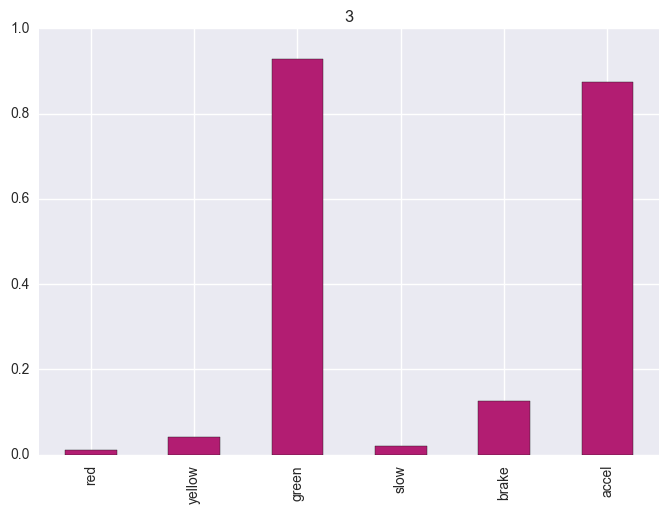

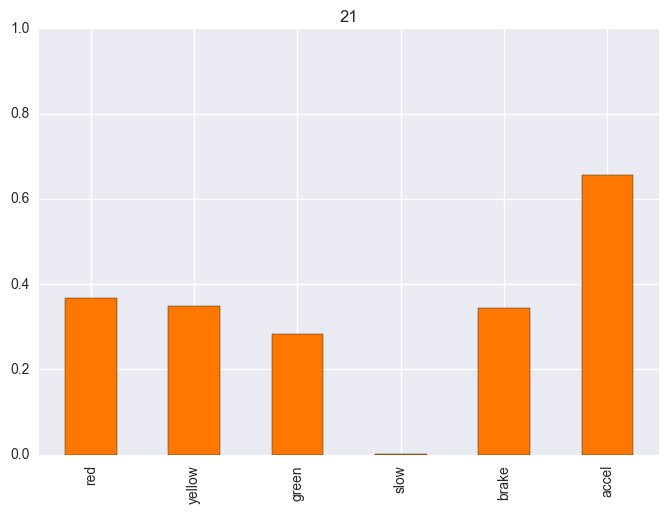

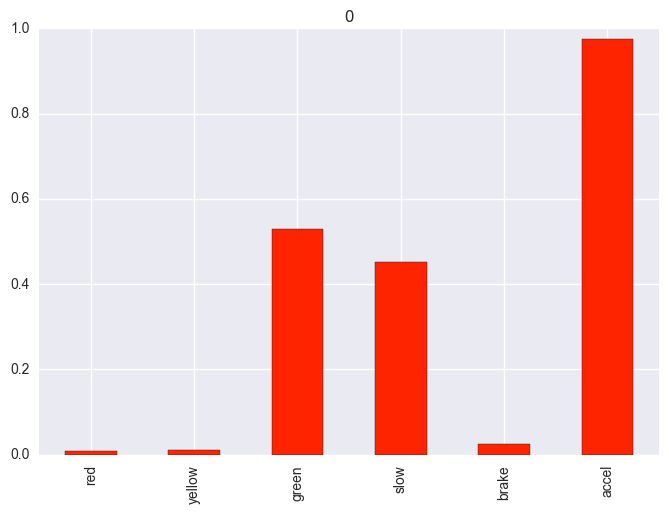

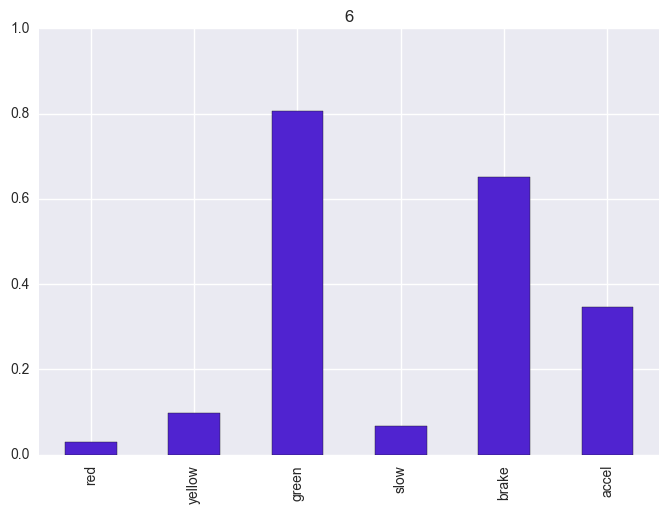

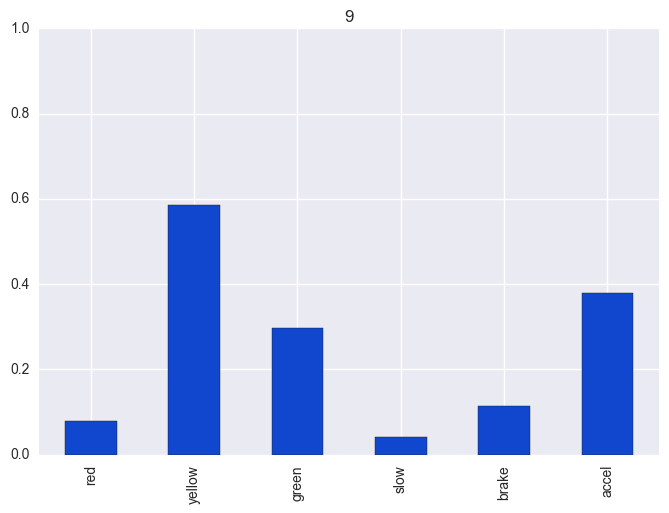

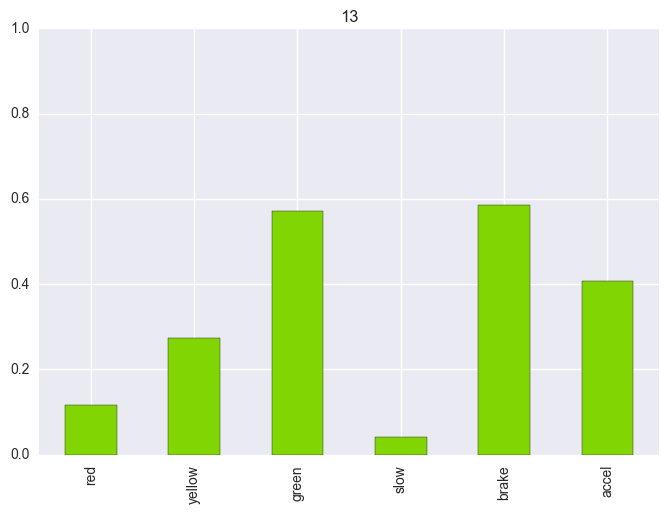

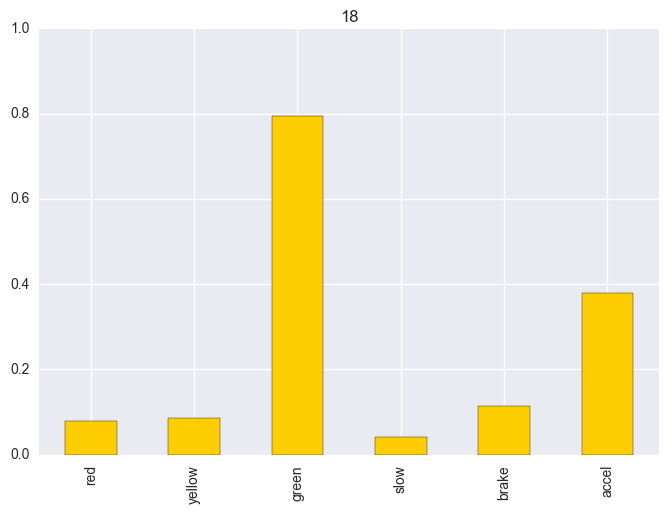

In [341]:
dir = "./img/Result1/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)

ref = ref[features]
for i in cls:
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.title(i)
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

### 結果の保存

In [342]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)

In [343]:
len(set(vb.predict(bf)))

7